In [1]:
import os
import numpy as np
import pandas as pd
from glob import glob
from datetime import datetime
from utils.sentinel_products_utils import get_S2prod_info
from utils.date_utils import get_doy
import matplotlib.pyplot as plt
%matplotlib inline

### User input

In [15]:
products_dir = "/media/michaeltrs/0a8a5a48-ede5-47d0-8eff-10d11350bf98/Satellite_Data/Sentinel2/MTLCC_AOI_2016_2017/S2PRODUCTS"
# "/media/michaeltrs/0a8a5a48-ede5-47d0-8eff-10d11350bf98/Satellite_Data/Sentinel2/France/T31TFL/2018"
ext = ".SAFE"

### Find products 

If a directory contains yest unzipped products we will parse product info from the filename following the [Sentinel product naming convention](https://sentinel.esa.int/web/sentinel/user-guides/sentinel-2-msi/naming-convention).

#### Compact Naming Convention

The compact naming convention is arranged as follows:

MMM_MSIXXX_YYYYMMDDHHMMSS_Nxxyy_ROOO_Txxxxx_<Product Discriminator>.ext

The products contain two dates.

The first date (YYYYMMDDHHMMSS) is the datatake sensing time.
The second date is the "<Product Discriminator>" field, which is 15 characters in length, and is used to distinguish between different end user products from the same datatake. Depending on the instance, the time in this field can be earlier or slightly later than the datatake sensing time.

The other components of the filename are:

- MMM: is the mission ID(S2A/S2B)
- MSIXXX: MSIL1C denotes the Level-1C product level/ MSIL2A denotes the Level-2A product level
- YYYYMMDDHHMMSS: the datatake sensing start time
- Nxxyy: the PDGS Processing Baseline number (e.g. N0204)
- ROOO: Relative Orbit number (R001 - R143)
- Txxxxx: Tile Number field
- ext: file extension either zip or SAFE: Product Format (Standard Archive Format for Europe)


In [16]:
filenames = [os.path.basename(fn) for fn in glob("%s/*%s" % (products_dir, ext))]
# print(filenames)
prodinfo = []
for fn in filenames:
    info = fn.split('_')
    year = info[2][:4]
    date = info[2][:8]
    size = int(os.path.getsize(os.path.join(products_dir, fn)))/1e6
    tile = info[5][1:]
    platformname = "Sentinel-%s" % info[0][1]
    processinglevel = "Level-%s" % info[1][-2:]
    prodinfo.append([fn, tile, platformname, processinglevel, year, date, size])
prodinfo = pd.DataFrame(
        prodinfo, columns=['filename', 'tile', 'platformname', 'processinglevel', 'year', 'date', 'Mb'])
prodinfo['doy'] = prodinfo['date'].apply(lambda s: get_doy(s))
prodinfo = prodinfo.sort_values('doy')
print("num data: ", prodinfo.shape[0])
print(prodinfo.head(5))

num data:  78
                                             filename   tile platformname  \
29  S2A_MSIL1C_20160110T101402_N0201_R022_T32UPU_2...  32UPU   Sentinel-2   
45  S2A_MSIL1C_20160120T101332_N0201_R022_T32UPU_2...  32UPU   Sentinel-2   
40  S2A_MSIL1C_20160120T101332_N0201_R022_T32UPU_2...  32UPU   Sentinel-2   
67  S2A_MSIL1C_20170127T102301_N0204_R065_T32UPU_2...  32UPU   Sentinel-2   
27  S2A_MSIL1C_20160130T101252_N0201_R022_T32UPU_2...  32UPU   Sentinel-2   

   processinglevel  year      date        Mb  doy  
29        Level-1C  2016  20160110  0.004096   10  
45        Level-1C  2016  20160120  0.004096   20  
40        Level-1C  2016  20160120  0.004096   20  
67        Level-1C  2017  20170127  0.004096   27  
27        Level-1C  2016  20160130  0.004096   30  


### Visualize downloaded product dates

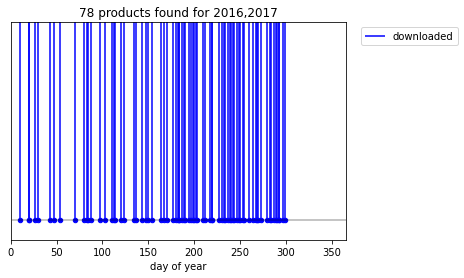

In [17]:
plt.title("%d products found for %s" % 
          (prodinfo['doy'].shape[0], ",".join(prodinfo['year'].drop_duplicates().tolist())))
plt.scatter(prodinfo['doy'].values, np.zeros(prodinfo.shape[0]), s=20, c='b')
#plt.scatter(uniform_doy_list, np.zeros(selected_doys.shape[0]), s=20, c='r')
plt.vlines(prodinfo['doy'].values, 0, 1, color='b', label='downloaded')
# plt.vlines(uniform_doy_list, 0, -1, color='r', label='uniform')
plt.hlines(0, 1, 365, color='k', alpha=0.3)
plt.ylim(-0.1, 1)
plt.xlim(0, 365)
plt.yticks([], [])
plt.xlabel('day of year')
plt.legend(bbox_to_anchor=(1.35, 1))

### Save downloaded products to disk

In [53]:
savename = '%s/downloaded_as_of_%s.csv' % \
           (products_dir, datetime.now().strftime('%Y%m%d_%H%M%S'))

if not os.path.exists(os.path.dirname(savename)):
    print("making new directory %s" % os.path.dirname(savename))
    os.makedirs(os.path.dirname(savename))

print("saving products info to %s" % savename)
prodinfo.to_csv(savename, index=False)

saving products info to /media/michaeltrs/0a8a5a48-ede5-47d0-8eff-10d11350bf98/Satellite_Data/Sentinel2/France/T31TFL/2018/cloud_0_20/downloaded_as_of_20210115_170411.csv
